<p>

### CHALLENGE 1: Time-series Forecasting

The "sample_dine_data.csv" file in the datasets directory contains 5 years of daily sales volume for an example store.

#### PROBLEM 2.1: Explore the data
Data Scientists are perputaul explorers. We look for patterns in data.

- What patterns can you find in this data in the sales data?
- Imagine this store recently came under new management. What results might you communicate to the new managers to help learn about the stores sales dynamics?

<p>

#### PROBLEM 1.2: Forecast 2018 Sales
At Rewards Network we deal with a lot of timeseries data both financial and behaivor. A classic time-series problem is forecasting. We'd like you to generate a forecast of 2019 daily sales for this store.

- Be sure to explain or demonstrate:
    - How you approach training, validation, testing, and prediction.
    - How you visualize your results
    - and How you assess model performance
- Export your final predictions to a csv file titled 'salesforecast_{yourname}.csv'
- Save you model to a pickly so we can quickly re-load the learned parameters

<p>

### CHALLENGE 2: Restaurant Classification
The following link points to a open source data set provided by the City of Chicago that tracks restaurant inspection outcomes since 2010:

https://data.cityofchicago.org/Health-Human-Services/Restaurant/5udb-dr6f

#### Problem 2.1: Inspection Predictions
Failed inspections directly impact our business. They are strong predictors of client churn and may worsen our members' experience.

We'd like you to generate a model that will predict whether or not a Chicago restaurant will fail its next inspection.

[we want to respect your time; do not feel compelled to explore more than a few top candidate features, but please explain why you believe the chosen features were good candidates and the insights you draw from them]
 
- Be sure to explain or demonstrate:
    - How you decide to define the target variable for your model
    - How you approach training, validation, test, and prediction
    - What features you explore
    - How you assess your features and their impact on you predictions
    - How you assess model performance
- Export your final predictions to a csv file titled 'inspectionprediction_{yourname}.csv'
- Save you model to a pickle so we can quickly re-load the learned parameters

In [2]:
import os
import re
import nltk
import string
import warnings
import operator
import uszipcode
import itertools
import textblob
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from textblob import TextBlob
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
from uszipcode import SearchEngine
from collections import Counter

In [3]:
data = pd.read_csv(r'C:\Users\vchauhan\Desktop\Sample_Code\data-science-coding-challenge\datasets\chicago_restaurant_inspections.csv')

In [4]:
"""Function Created to help in different situations"""

def check_missing(data):
    col_mv = {}
    for i in list(data.columns):
        null_val = data[i].isnull().sum()
        if null_val!=0:
            col_mv[i] =  int(null_val)
    if col_mv:
        return sorted(col_mv.items(), key=operator.itemgetter(1))
    else:
        print("No Null Values")
        
        
def convertInteger(data, column):
    for i in range(0, len(data[column])):
        try:
            data[column].iat[i] = int(data[column].iat[i])
        except:
            pass
    return data[column]


def getFirstElemList(data, column):
    violation_numbers = []
    for elem in data[column]:
        try:
            elem2 = [i.split('.') for i in elem]
            elem_number = [item[0] for item in elem2]
            violation_numbers.append(elem_number)
        except:
            violation_numbers.append(elem) 
    return violation_numbers

def detect_polarity(text):
    try:
        TextBlob(text).sentiment.polarity
    except:
        pass
    
stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
def clean_text(data):
    try:
        text= ''.join([word.lower() for word in data if word not in string.punctuation])
        text= re.sub('[0-9]+', '', text)
        text_token = re.split('\W+', text)
        text = [word for word in text_token if word not in stopword]
        text = [ps.stem(word) for word in text]
        text = ' '.join(text)
        return text
    except:
        pass
    
    
def barplot(data, data_group_column, attribute, number =25):
    target  = data.groupby(data_group_column)[attribute].mean().nlargest(number)
    z = []
    for i in range(len(target)):
        z.append(i+1)

    plt.figure(figsize=(10,7))
    plt.subplot(211)
    plt.bar(z, list(target), align='center', color ='mediumturquoise')
    labels = target.index
    plt.yticks(fontsize=10)
    plt.xticks(z, labels, fontsize=10, rotation = 90)
    plt.show() 

In [5]:
data['Results'].unique()

array(['Fail', 'Pass w/ Conditions', 'Pass', 'Not Ready', 'No Entry',
       'Out of Business', 'Business Not Located'], dtype=object)

In [6]:
### We will remove the data where Results are Out of Business, Business Not Located and Not Ready (Don't know what that means)
### If a restaurant is out of the business, then there is very less probability of that being our client. Same is the case
### with the Business Not Located.

data = data[~data['Results'].isin(['Not Ready', 'No Entry', 'Out of Business', 'Business Not Located'])]

In [7]:
"""As we can see from the following that Most of the missing values are in Violations which can be one of the important 
factors while predicting the result of an inspection. Apart from that there are missing values in AKA Name, Location,
Latitude and Longitude which we will not be using because we have zip code and state which we can use alternatively. We can
drop the null values from city as they are very few in number. Same is the case with Risk and inspection"""

check_missing(data)

[('Inspection Type', 1),
 ('Risk', 2),
 ('Zip', 13),
 ('State', 17),
 ('City', 52),
 ('Latitude', 149),
 ('Longitude', 149),
 ('Location', 149),
 ('AKA Name', 683),
 ('Violations', 14545)]

In [8]:
"""Here we will remove the missing values from the data and also we will change data types to deal with missing data"""

data = data[~data['AKA Name'].isnull()]
data = data[~data['Location'].isnull()]
data = data[~data['Risk'].isnull()]
data = data[~data['Inspection Type'].isnull()]
data = data[~data['Zip'].isnull()]

# data['City'] = data['City'].fillna('NA')
# data['State'] = data['State'].fillna('NA')
data['Zip'] = data['Zip'].astype(int)

In [9]:
"""Now we will make use of library from python to find the city based on the zipcode. This will help us in keeping the data
which will help us for training and testing purpose instead of removing"""

search = SearchEngine()
city = []
for i in range(0, len(data)):
    if pd.isnull(data['City'].iloc[i]):
        city.append(search.by_zipcode(data['Zip'].iloc[i]).major_city)
    else:
        city.append(data['City'].iloc[i])
    
state = []
for i in range(0, len(data)):
    if pd.isnull(data['State'].iloc[i]):
        state.append(search.by_zipcode(data['Zip'].iloc[i]).state)
    else:
        state.append(data['State'].iloc[i])

In [10]:
data['City']  = city
data['State'] = state

In [11]:
""" Now we have dealt with all the missing values apart from violations. Let's tackle this now"""

check_missing(data)

[('Violations', 14307)]

In [12]:
"""We can see that there are codes for violations at the very beginning. Let's use those instead of sentences for our analysis.
Also number of violation for both pass results and fail results are more than One. So we have to consider all of them while doing
analysis"""
data['Violations_New'] = data['Violations'].str.split('|') 
data['Violations_New'] = getFirstElemList(data, 'Violations_New')
data['Violations_New'] = data['Violations_New'].fillna('NA')
data['Violation_Length'] = data['Violations_New'].apply(len) ## To see if number of violations has any effect on result

In [13]:
"""Just keeping two categories at the moment. Converting pass with consditions to pass as well"""
data['Results'] = ['Pass' if 'Pass' in i else 'Fail' for i in data['Results']]

In [14]:
"""Now I want to see if there are any Violation Number which are overlapping in both pass and fail category. If they are not 
then we will just label the violations as bad and good to avoid the complications in the analysis.
From the below number we can clearly see that number of violations for the restaurant which Failed Inspection has twice the 
violations as which passed. So we will include this feature into the model"""

pass_data = data[data['Results'] == 'Pass']
pass_data = pass_data.dropna()
fail_data = data[data['Results'] == 'Fail']
fail_data = fail_data.dropna()
print("Average number of violation where restaurant passed the inspection is " + str(pass_data['Violation_Length'].mean()) )
print("Average number of violation where restaurant passed the inspection is " + str(fail_data['Violation_Length'].mean()) )

Average number of violation where restaurant passed the inspection is 3.9801307847082494
Average number of violation where restaurant passed the inspection is 6.768634810644339


In [15]:
violations_pass = list(pass_data['Violations_New'])
violations_pass = list(itertools.chain.from_iterable(violations_pass))
violations_pass_set = set(violations_pass)
Number_of_violation_pass = Counter(violations_pass)
Number_of_violation_pass = {k: v for k, v in sorted(Number_of_violation_pass.items(), key=lambda item: item[1], reverse=True)}

violations_fail = list(fail_data['Violations_New'])
violations_fail = list(itertools.chain.from_iterable(violations_fail))
violations_fail_set = set(violations_pass)
Number_of_violation_fail = Counter(violations_fail)
Number_of_violation_fail = {k: v for k, v in sorted(Number_of_violation_fail.items(), key=lambda item: item[1], reverse=True)}

In [16]:
Number_of_violation_pass

{' 34': 27211,
 ' 35': 25342,
 ' 38': 22075,
 ' 33': 20578,
 '32': 15683,
 ' 41': 13179,
 ' 36': 11101,
 ' 32': 11000,
 '33': 10862,
 ' 55': 8512,
 '3': 7919,
 '30': 7142,
 ' 40': 6995,
 ' 5': 5441,
 '34': 5374,
 ' 43': 5221,
 ' 58': 5052,
 ' 45': 4811,
 ' 37': 4198,
 ' 47': 3922,
 ' 42': 3528,
 ' 51': 3085,
 '31': 2885,
 ' 56': 2795,
 ' 23': 2758,
 '21': 2724,
 '35': 2631,
 ' 49': 2613,
 ' 31': 2538,
 '2': 2402,
 ' 3': 2237,
 '38': 2182,
 ' 57': 2161,
 ' 25': 2130,
 ' 30': 2106,
 ' 10': 1998,
 ' 53': 1298,
 ' 39': 1241,
 ' 21': 1148,
 '5': 913,
 ' 16': 883,
 '16': 859,
 '36': 808,
 ' 44': 786,
 '8': 699,
 '10': 657,
 '6': 624,
 '41': 614,
 ' 22': 571,
 ' 48': 538,
 '1': 477,
 '14': 473,
 '37': 460,
 '12': 442,
 ' 28': 402,
 ' 8': 383,
 ' 29': 363,
 '47': 354,
 ' 60': 350,
 '40': 349,
 '11': 347,
 ' 12': 346,
 '55': 337,
 '45': 335,
 ' 2': 277,
 ' 6': 275,
 '28': 261,
 '25': 255,
 '49': 247,
 '23': 239,
 ' 54': 233,
 '29': 212,
 ' 11': 208,
 '51': 206,
 ' 61': 157,
 '9': 157,
 ' 9': 15

In [17]:
Number_of_violation_fail

{' 34': 11138,
 ' 33': 10527,
 ' 38': 10445,
 ' 35': 10337,
 ' 32': 9124,
 ' 41': 5918,
 ' 36': 5149,
 '18': 5013,
 ' 18': 4002,
 ' 55': 3952,
 ' 30': 3082,
 '3': 3021,
 ' 40': 3019,
 ' 29': 2675,
 '2': 2303,
 ' 21': 2153,
 ' 37': 2025,
 ' 43': 2013,
 ' 31': 1954,
 ' 5': 1936,
 ' 16': 1804,
 ' 47': 1784,
 ' 45': 1764,
 ' 10': 1686,
 ' 58': 1681,
 '16': 1680,
 ' 3': 1662,
 ' 49': 1428,
 ' 19': 1420,
 ' 51': 1419,
 '29': 1304,
 ' 42': 1277,
 ' 56': 1223,
 ' 24': 1155,
 '11': 1101,
 ' 57': 1049,
 ' 23': 1031,
 ' 22': 980,
 ' 25': 894,
 ' 48': 839,
 ' 39': 724,
 '19': 708,
 ' 53': 678,
 ' 12': 622,
 '8': 609,
 ' 60': 582,
 ' 11': 582,
 '24': 542,
 '12': 485,
 '10': 479,
 ' 54': 458,
 ' 28': 451,
 '1': 438,
 '6': 436,
 ' 8': 435,
 '14': 375,
 ' 44': 359,
 '9': 354,
 '21': 331,
 ' 9': 300,
 ' 26': 284,
 '5': 256,
 ' 2': 251,
 ' 6': 236,
 '22': 226,
 ' 70': 188,
 ' 59': 165,
 ' 13': 162,
 ' 52': 151,
 '38': 145,
 '26': 145,
 '13': 142,
 ' 14': 135,
 ' 50': 129,
 '32': 123,
 ' 61': 93,
 '4': 7

In [25]:
"""From the above two dictionaries we can see that it's very confusing to find which violation is actually responsible for
Failing or Passing the Inspection Test. To tackle this problem let's use sentiment analysis on the Violations. I will not be
going into much detail. I won't be building a sentiment analysis model from scratch instead i will be using Textblob"""

text = []
for i in data['Violations']:
    try:
        text.append(clean_text(i))
    except:
        text.append(i)

data['Violations'] = text

polarity = []
for i in data['Violations']:
    try:
        polarity.append(TextBlob(i).sentiment.polarity)
    except:
        polarity.append(i)

In [26]:
data['Polarity'] = polarity

In [18]:
data['Year'] = pd.to_datetime(data['Inspection Date']).dt.year

In [19]:
data

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Violations_New,Violation_Length,Year
0,MANOLO'S TAMALES #3,MANOLO'S TAMALES #3,2307811,Restaurant,Risk 1 (High),2455 S KEDZIE AVE,CHICAGO,IL,60623,12/04/2018,Complaint Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.846539,-87.704953,"(41.846538888991475, -87.70495285575998)","[3, 5, 23, 25, 37, 38, 38, 41, 44, 45...",20,2018
1,WOLFGANG EXPRESS,WOLFGANG PUCK EXPRESS (T3 K12),34199,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666,03/26/2019,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)","[10, 36, 49, 51, 51, 55, 55, 56, 56, ...",11,2019
2,PASTORAL,BAR PASTORAL,2157189,Restaurant,Risk 1 (High),2945-2947 N BROADWAY AVE,CHICAGO,IL,60657,08/02/2019,Canvass,Pass,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.936248,-87.644121,"(41.93624830273888, -87.64412091275041)","[1, 2, 8, 23, 25, 37, 43, 47, 51, 53,...",12,2019
3,JIEYI SUSHI,JIEYI SUSHI,2506880,Restaurant,Risk 1 (High),1178 N MILWAUKEE AVE,CHICAGO,IL,60642,06/25/2019,Canvass Re-Inspection,Pass,23. PROPER DATE MARKING AND DISPOSITION - Comm...,41.903119,-87.666337,"(41.90311911873191, -87.6663365256722)","[23, 25, 47, 47, 47, 49, 55, 55]",8,2019
4,GHAREEB NAWAZ RESTAURANT,GHAREEB NAWAZ RESTAURANT,2423912,Restaurant,Risk 1 (High),2032-2036 W Devon AVE,CHICAGO,IL,60659,04/02/2019,Suspected Food Poisoning,Pass,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.997984,-87.681420,"(41.99798375025185, -87.68142044788961)","[3, 5, 9, 21, 22, 23, 37, 39, 39, 40,...",17,2019
5,CHICAGO PIZZA & OVEN GRINDER,CHICAGO PIZZA & OVEN GRINDER,28176,Restaurant,Risk 1 (High),2121 N CLARK ST,CHICAGO,IL,60614,02/25/2019,Canvass,Pass,23. PROPER DATE MARKING AND DISPOSITION - Comm...,41.920808,-87.637425,"(41.92080847859943, -87.63742463183816)","[23, 53, 55, 55]",4,2019
6,COMPASS BAR,COMPASS BAR,2222223,Restaurant,Risk 1 (High),433 W DIVERSEY PKWY,CHICAGO,IL,60614,07/30/2018,Canvass,Pass,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.932774,-87.640685,"(41.93277423124578, -87.64068504180638)","[3, 5, 23, 25, 47, 51, 55, 55, 55, 55...",11,2018
7,SUBWAY,SUBWAY,1492342,Restaurant,Risk 1 (High),5901 S ARCHER AVE,CHICAGO,IL,60638,03/14/2019,Canvass,Pass,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.795516,-87.762925,"(41.79551639442828, -87.76292466014908)","[2, 3, 40, 49, 53, 55, 55, 58]",8,2019
8,ZAIQA RESTAURANT,ZAIQA RESTAURANT,2632018,Restaurant,Risk 1 (High),2245 W DEVON AVE,CHICAGO,IL,60659,08/26/2019,Canvass,Fail,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.997674,-87.686756,"(41.9976744700477, -87.6867563084304)","[2, 22, 37, 38, 38, 39, 39, 40, 41, 4...",21,2019
9,CHISME EXPRESS INC.,CHISME EXPRESS INC.,1334960,Restaurant,Risk 1 (High),5955 S PULASKI RD,CHICAGO,IL,60629,01/27/2015,Complaint,Pass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.784289,-87.722771,"(41.784288983210146, -87.72277078477818)","[30, 32, 33, 33, 34, 34, 35, 35, 38, ...",11,2015


In [21]:
"""We can see that there is difference in the polarity score but it doesn't look too much. But still we will consider that as
a feature"""

pass_data_polarity = data[data['Results'] == 'Pass']
fail_data_polarity = data[data['Results'] == 'Fail']
print("Average Polarity Score for Pass is "  + str(pass_data_polarity['Polarity'].mean()))
print("Average Polarity Score for Fail is "  + str(fail_data_polarity['Polarity'].mean()))

In [54]:
def barplot_count(data, data_group_column, attribute):
    target  = data.groupby(data_group_column)[attribute].count()
    z = []
    for i in range(len(target)):
        z.append(i+1)

    plt.figure(figsize=(20,12))
    plt.subplot(211)
    plt.bar(z, list(target), align='center', color ='mediumturquoise')
    labels = target.index
    plt.yticks(fontsize=10)
    plt.xticks(z, labels, fontsize=10, rotation = 90)
    plt.show()

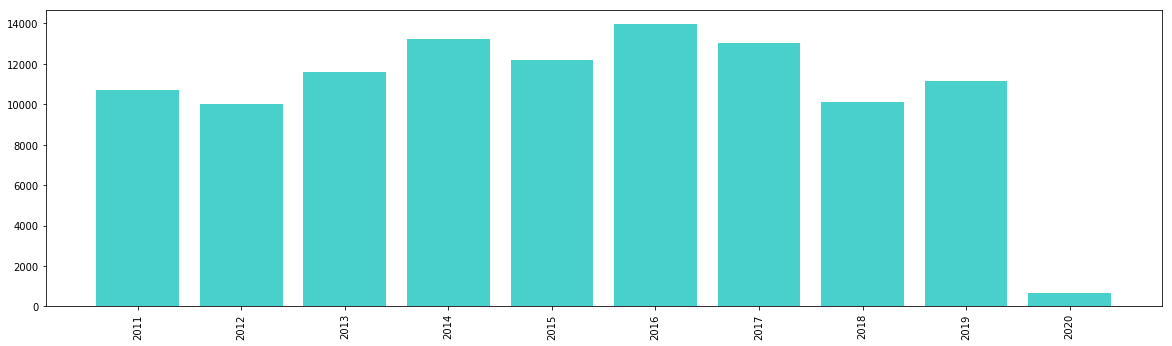

In [55]:
"""This is showing us the Number of inxpections per year"""
barplot_count(data, 'Year', 'Results')

<Figure size 1080x504 with 0 Axes>

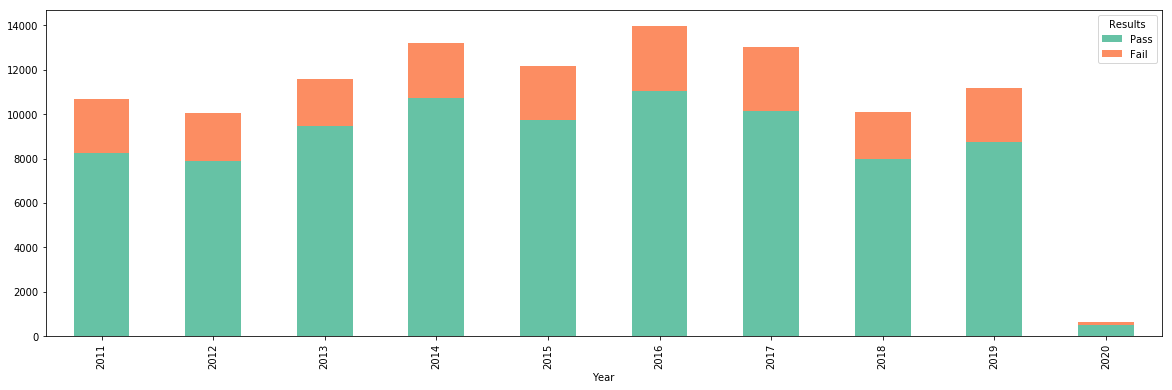

In [57]:
"""From the below plot we can see the number of pass and fail inspections per year and it is clear that there is imabalnce in
data. Data with Failed inspection are 1/4 times the pass inspections."""

plt.figure(figsize=(15, 7))
pal = sns.color_palette("Set2")
data_groupby = data.groupby(['Year', 'Results'])['Results'].count().unstack('Results').fillna(0)
data_groupby[['Pass','Fail']].plot(kind='bar', stacked=True, color=pal, figsize=(20, 6))

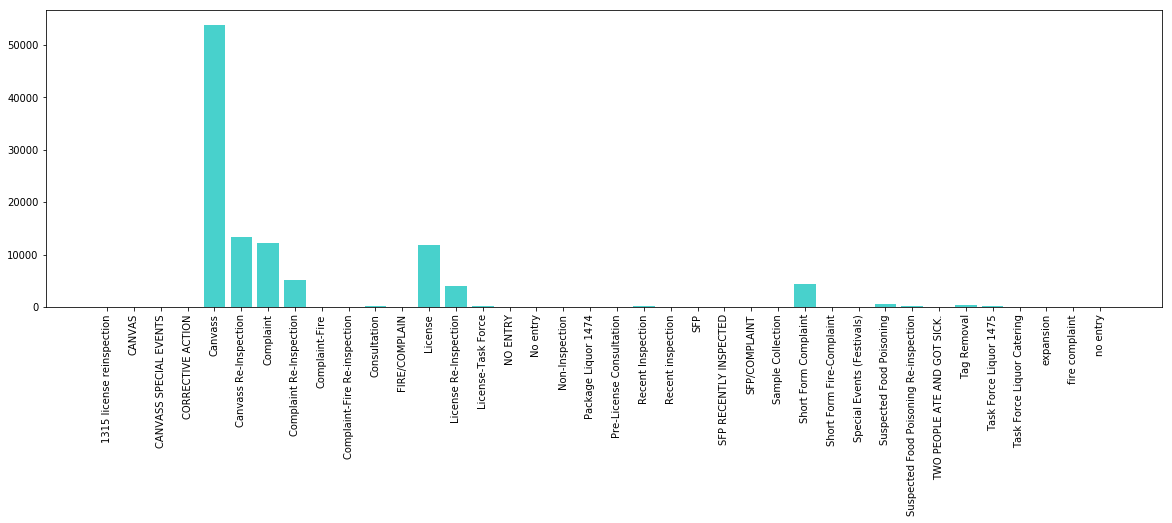

In [58]:
"""From the below plot what we can see the various Inspection Type for the data. We can infer that most of the inspections
were of type Canvas which is almost 50% this will cause imbalance or bias because of the feature so we need to pre process this
by combining various Inspection Type. At the moment i will keep it like that. Because i need to understand what each 
Inspection Type means and that i get to know from buisness people only"""

barplot_count(data, 'Inspection Type', 'Results')

In [59]:
"""As we can see that there is only one city and State in the data. So we won't be including this as a feature"""

print(data['City'].unique())
print(data['State'].unique())

['CHICAGO' 'Chicago' 'chicago' 'CHICAGOCHICAGO' 'CCHICAGO' 'CHICAGO.'
 'CHICAGOHICAGO' 'CHICAGOI' '312CHICAGO']
['IL']


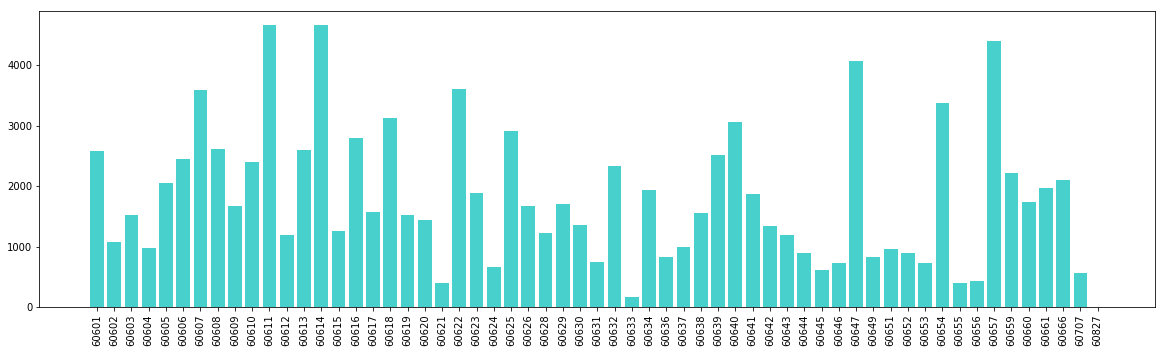

In [60]:
"""From the bar chart below we can clearly see that number of inspections varies by zipcode and that may be because some
zipcodes have more restaurants than other."""
barplot_count(data, 'Zip', 'Results')

<Figure size 1080x504 with 0 Axes>

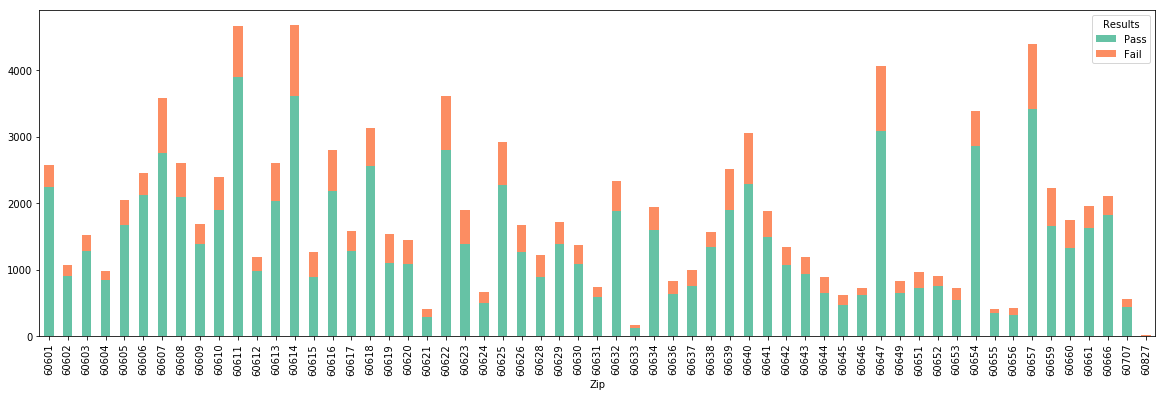

In [61]:
"""Following plot shows us the """

plt.figure(figsize=(15, 7))
pal = sns.color_palette("Set2")
data_groupby = data.groupby(['Zip', 'Results'])['Results'].count().unstack('Results').fillna(0)
data_groupby[['Pass','Fail']].plot(kind='bar', stacked=True, color=pal, figsize=(20, 6))

In [63]:
data_groupby['Ratio_Fail_Inspection'] = data_groupby['Fail'] / (data_groupby['Fail'] + data_groupby['Pass']) 

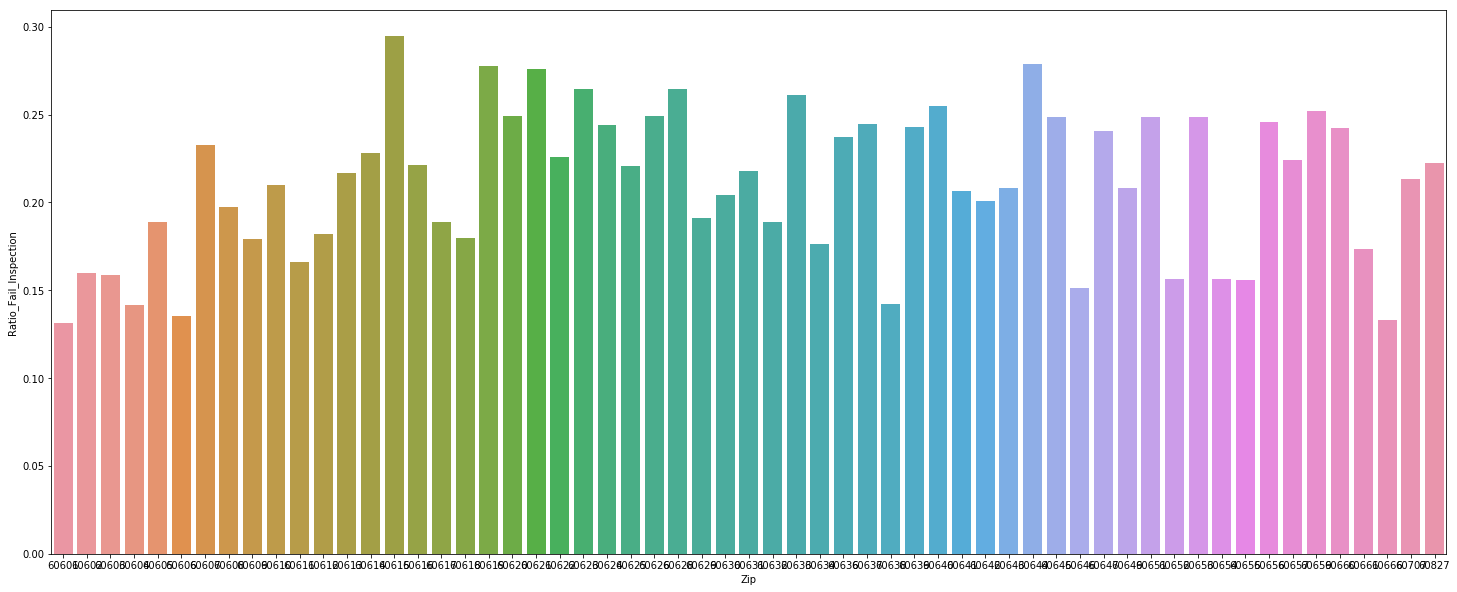

In [69]:
plt.figure(figsize=(25, 10))
sns.barplot(data_groupby.index, data_groupby['Ratio_Fail_Inspection'])

In [66]:
data_groupby

Results,Fail,Pass,Ratio_Fail_Inspection
Zip,,,
60601,338,2237,0.131262
60602,171,898,0.159963
60603,241,1280,0.158448
60604,139,842,0.141692
60605,387,1663,0.188780
60606,332,2119,0.135455
60607,833,2750,0.232487
60608,515,2092,0.197545
60609,301,1377,0.179380


In [18]:
### From this we can see that restaurant can have more than one inspection as well
### So we need to preprocess based on the features and avoid duplicates from data
data[data['License #'] == 34199]

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Violations_New,Violation_Length
1,WOLFGANG EXPRESS,WOLFGANG PUCK EXPRESS (T3 K12),34199,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666,03/26/2019,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)","[10, 36, 49, 51, 51, 55, 55, 56, 56, ...",11
2977,WOLFGANG EXPRESS,WOLFGANG PUCK EXPRESS (T3 K12),34199,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666,09/25/2019,Canvass,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)","[10, 55, 55, 56, 57]",5
12801,WOLFGANG EXPRESS,WOLFGANG PUCK EXPRESS (T3 K12),34199,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666,04/05/2018,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)","[18, 32, 34, 35, 45]",5
29248,WOLFGANG EXPRESS,WOLFGANG PUCK EXPRESS (T3 K12),34199,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666,05/16/2017,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)","[33, 34, 35]",3
30951,WOLFGANG EXPRESS,WOLFGANG PUCK EXPRESS (T3 K12),34199,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666,11/09/2012,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)","[33, 34, 35, 38]",4
33303,WOLFGANG EXPRESS,WOLFGANG PUCK EXPRESS (T3 K12),34199,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666,06/07/2013,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)","[33, 34]",2
34883,WOLFGANG EXPRESS,WOLFGANG PUCK EXPRESS (T3 K12),34199,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666,11/04/2011,Tag Removal,Pass,NaN,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)",NA,2
35185,WOLFGANG EXPRESS,WOLFGANG PUCK EXPRESS (T3 K12),34199,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666,04/12/2018,Canvass Re-Inspection,Pass,"9. WATER SOURCE: SAFE, HOT & COLD UNDER CITY P...",42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)","[9, 32, 34]",3
35919,WOLFGANG EXPRESS,WOLFGANG PUCK EXPRESS (T3 K12),34199,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666,10/24/2014,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)","[33, 34, 35, 38]",4
37804,WOLFGANG EXPRESS,WOLFGANG PUCK EXPRESS (T3 K12),34199,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666,09/13/2018,Canvass,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)","[10, 47, 49, 55, 56, 57]",6


In [19]:
### There is only One Facility Type, so we will remove this from the set of features.
data['Facility Type'].unique()

array(['Restaurant'], dtype=object)

In [20]:
data['Risk'].unique()

array(['Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)'], dtype=object)

<p>

### CHALLENGE 3: Market Clustering
The 'food_environement_atlas.xls' excel file in the datasets directory contains a wide variety of food availability metrics across counties (counties are uniquely identified by a FIPS is). Full documentation on all the terms can be found here:

https://www.ers.usda.gov/data-products/food-environment-atlas/documentation

#### Problem 3.1: Characterizing Markets
At Rewards Network, our mission is to partner in the growth of local restaurants. To do this we need to understand the market context within which each restaurant is situated.

Treating each county as its own market, we'd like you to identify a set of market clusters that can help us categorize our clients market environement and potentially inform our strategy to help them grow.

[Again, don't feel compelled to use all the data; Efficiency is a virtue; Try to assess which data will likely be informative to the challenge]
 
- Be sure to explain or demonstrate:
    - Why you chose the data selected for clustering
    - How you pre-process the data
    - How you choose an appropriate clustering algorihtm
    - Why you determine the number of clusters
    - How you assess model performance
    - How you can characterize your clusters in terms or metrics that would be salient to a Marketer or Sales-Rep
- Export your final predictions to a csv file titled 'marketclusters_{yourname}.csv'
- Save you model to a pickle so we can quickly re-load the learned parameters

<p>